In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

#import river, an online learning library
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from river import feature_selection
from river import stats
from river import imblearn
from river import preprocessing
from river import evaluate
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river import drift
from river import forest
from river.drift import ADWIN,KSWIN,PageHinkley
from river.drift.binary import DDM,EDDM,HDDM_A,HDDM_W

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Read the CSV file into a DataFrame
df = pd.read_csv("C:\\Users\\jaswa\\Downloads\\IoT Network Intrusion Dataset-20230802T155717Z-001\\IoT Network Intrusion Dataset\\IoT Network Intrusion Dataset.csv")

# Encode all object columns using LabelEncoder
label_encoder = LabelEncoder()

for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

print(df)

        Flow_ID  Src_IP  Src_Port  Dst_IP  Dst_Port  Protocol  Timestamp  \
0         12446   25883     10000     203     10101        17       3496   
1         22760   34617      2179     200       554         6       3664   
2         12691   25886     52727     200      9020         6       2082   
3         12704   25886     52964     200      9020         6        791   
4           611   25881     36763     317      1900        17       1040   
...         ...     ...       ...     ...       ...       ...        ...   
625778    62081   25889     56112     233      8043        17       3443   
625779    18760   30623      4570     200       554         6       3637   
625780    12695   25886     52739     200      9020         6       2285   
625781    12682   25883      9020     203     49784         6       2872   
625782    12446   25883     10000     203     10101        17       3453   

        Flow_Duration  Tot_Fwd_Pkts  Tot_Bwd_Pkts  ...  Active_Std  \
0                

In [3]:
ranking = np.array([84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 68, 66, 64, 56, 55, 54, 49, 41, 39, 38, 37, 36, 30, 29, 27, 21, 20, 19, 18, 16, 14, 13, 12, 10, 8, 7, 6, 5, 3, 2, 1, 0])  # Replace this with your actual ranking list

In [23]:
df = df.head(int(len(df)*(10/100)))
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.1, test_size=0.9, shuffle=False,random_state = 0)

In [24]:
def adaptive_learning(X_train, y_train, X_test, y_test, ranking):
    metric = metrics.Accuracy()  # Use accuracy as the metric
    d = 0
    c = 0  # counts no of drifts
    i = 0  # count the number of evaluated data points
    t = []  # record the number of evaluated data points
    m = []  # record the real-time accuracy
    yt = []  # record all the true labels of the test set
    yp = []  # record all the predicted labels of the test set

    eddm = EDDM()

    num_features = 10

    while True: 
        
        b = True
        selected_features = ranking[:num_features]

        # Modify your model to use selected features
        selected_model = tree.ExtremelyFastDecisionTreeClassifier()

        selected_X_train = X_train.iloc[:, selected_features]
        selected_X_test = X_test.iloc[:, selected_features]

        # Learn the training set using the selected features
        for xi1, yi1 in stream.iter_pandas(selected_X_train, y_train):
            selected_model.learn_one(xi1, yi1)

        # Predict and detect drift using selected features
        for xi, yi in stream.iter_pandas(selected_X_test, y_test):
            y_pred = selected_model.predict_one(xi)
            selected_model.learn_one(xi, yi)

            metric = metric.update(yi, y_pred)

            val = 0
            if yi != y_pred:
                val = 1
            eddm.update(float(val))
            if eddm.drift_detected:
                c = c + 1
                print("Change detected at index", i)
            if c == 3 and num_features < 40:
                c = 0
                num_features += 10
                b = False
                break

            t.append(i)
            m.append(metric.get() * 100)
            yt.append(yi)
            yp.append(y_pred)
            i += 1
            
        if b:
            break
        else:
            continue

    # Print evaluation metrics and return values
    print("Accuracy:", round(accuracy_score(yt, yp), 4) * 100, "%")
    print("Precision:", round(precision_score(yt, yp, zero_division=1), 4) * 100, "%")
    print("Recall:", round(recall_score(yt, yp, zero_division=1), 4) * 100, "%")
    print("F1-score:", round(f1_score(yt, yp, zero_division=1), 4) * 100, "%")
    return t, m, c

In [25]:
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Accuracy: 100.0 %
Precision: 100.0 %
Recall: 100.0 %
F1-score: 100.0 %
no of drifts:  0
Wall time: 29.1 s


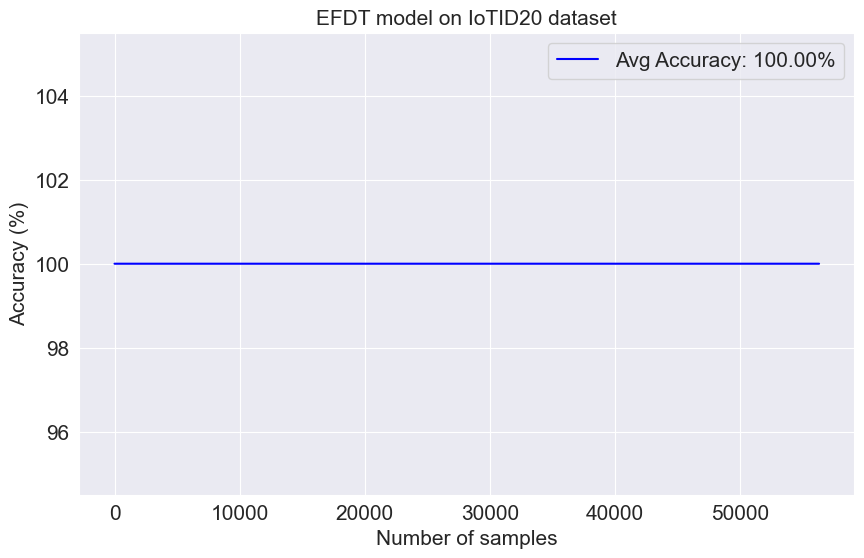

In [26]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model 
name = "EFDT model"
model = tree.ExtremelyFastDecisionTreeClassifier() # Define the model
t, m, c = adaptive_learning(X_train, y_train, X_test, y_test, ranking) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples
print("no of drifts: ",c)